# Binary Classifiaction with a Bank Churn Dataset using Neural Network

Note: Description

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

### Data Load

In [2]:
# Data Load
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

### EDA

In [3]:
# Display the first few rows of the dataset
print("First few rows of the training dataset:")
print(df_train.head())

First few rows of the training dataset:
   id  CustomerId         Surname  CreditScore Geography Gender   Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male  33.0       3   
1   1    15749177   Okwudiliolisa          627    France   Male  33.0       1   
2   2    15694510           Hsueh          678    France   Male  40.0      10   
3   3    15741417             Kao          581    France   Male  34.0       2   
4   4    15766172       Chiemenam          716     Spain   Male  33.0       5   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              2        1.0             0.0        181449.97   
1       0.00              2        1.0             1.0         49503.50   
2       0.00              2        1.0             0.0        184866.69   
3  148882.54              1        1.0             1.0         84560.88   
4       0.00              2        1.0             1.0         15068.83   

   Exited  
0       0 

In [4]:
# Display information about the dataset
print("\nInformation about the training dataset:")
df_train.info()


Information about the training dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [5]:
# Display the shape of the dataset
print("\nShape of the training dataset:")
df_train.shape


Shape of the training dataset:


(165034, 14)

In [6]:
# Display descriptive statistics for numerical features
print("\nDescriptive statistics for numerical features:")
df_train.describe().style.format(precision=2).background_gradient(cmap="RdPu")


Descriptive statistics for numerical features:


,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.00,165034.00,165034.00,165034.00,165034.00,165034.00,165034.00,165034.00,165034.00,165034.00,165034.00
mean,82516.50,15692005.02,656.45,38.13,5.02,55478.09,1.55,0.75,0.50,112574.82,0.21
std,47641.36,71397.82,80.10,8.87,2.81,62817.66,0.55,0.43,0.50,50292.87,0.41
min,0.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,41258.25,15633141.00,597.00,32.00,3.00,0.00,1.00,1.00,0.00,74637.57,0.00
50%,82516.50,15690169.00,659.00,37.00,5.00,0.00,2.00,1.00,0.00,117948.00,0.00
75%,123774.75,15756824.00,710.00,42.00,7.00,119939.52,2.00,1.00,1.00,155152.47,0.00
max,165033.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


In [7]:
# Check for missing values
print("\nMissing values in the training dataset:")
df_train.isnull().sum()


Missing values in the training dataset:


id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

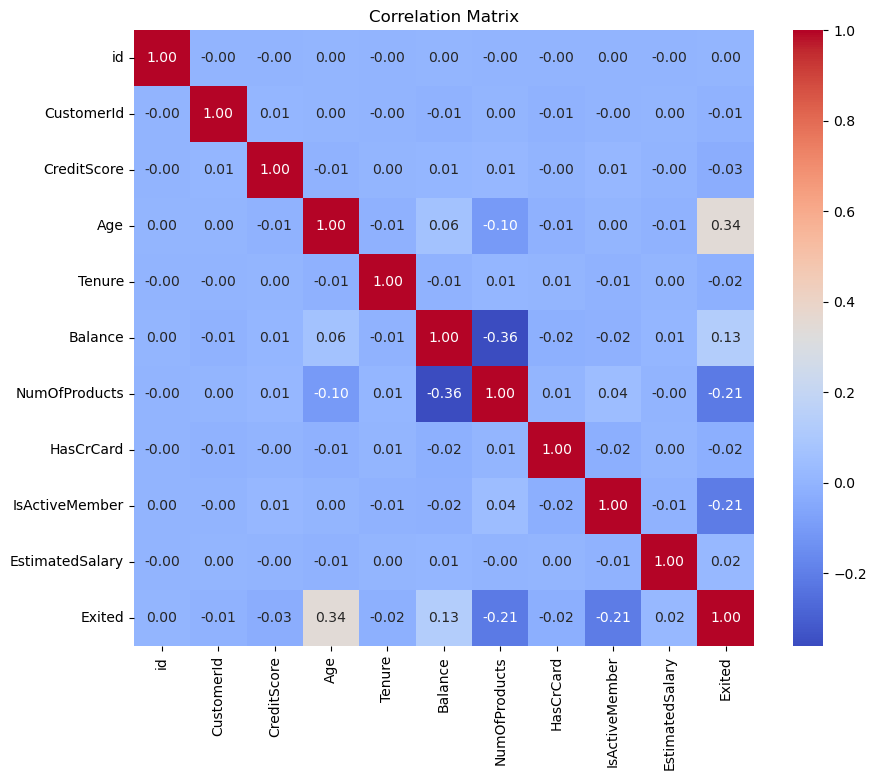

In [8]:
# Exclude non-numeric columns
numeric_columns = df_train.select_dtypes(include=[np.number]).columns
numeric_df = df_train[numeric_columns]

# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

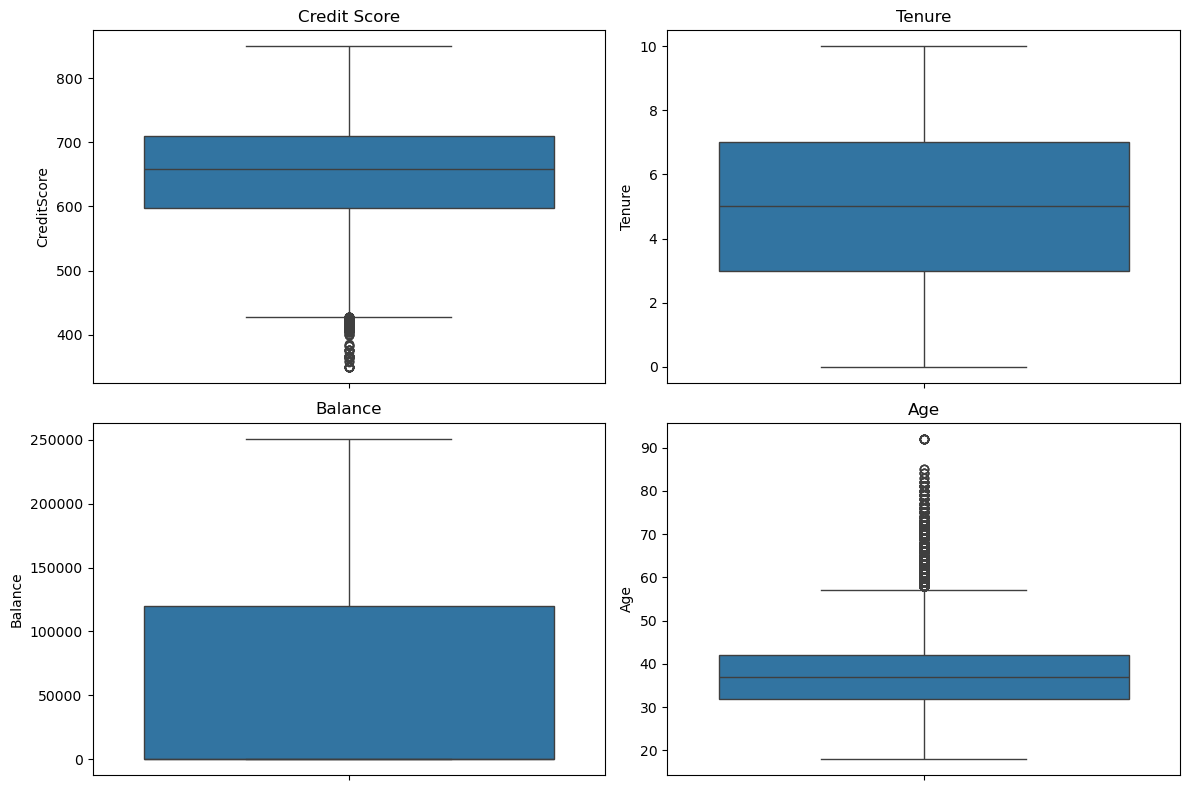

In [9]:
# Distribution and Outliers for each numerical column
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.boxplot(ax=axes[0, 0], data=df_train['CreditScore'])
axes[0, 0].set_title('Credit Score')

sns.boxplot(ax=axes[0, 1], data=df_train['Tenure'])
axes[0, 1].set_title('Tenure')

sns.boxplot(ax=axes[1, 0], data=df_train['Balance'])
axes[1, 0].set_title('Balance')

sns.boxplot(ax=axes[1, 1], data=df_train['Age'])
axes[1, 1].set_title('Age')

plt.tight_layout()
plt.show()


In [10]:
# Finding the median values for CreditScore and Age
median_credit_score = df_train['CreditScore'].median()
median_age = df_train['Age'].median()

# Determining the upper and lower thresholds for outliers
upper_credit_score = df_train['CreditScore'].quantile(0.95)
lower_credit_score = df_train['CreditScore'].quantile(0.05)
upper_age = df_train['Age'].quantile(0.95)
lower_age = df_train['Age'].quantile(0.05)

# Replacing outliers with median values
df_train['CreditScore'] = np.where(df_train['CreditScore'] > upper_credit_score, median_credit_score, df_train['CreditScore'])
df_train['CreditScore'] = np.where(df_train['CreditScore'] < lower_credit_score, median_credit_score, df_train['CreditScore'])
df_train['Age'] = np.where(df_train['Age'] > upper_age, median_age, df_train['Age'])
df_train['Age'] = np.where(df_train['Age'] < lower_age, median_age, df_train['Age'])


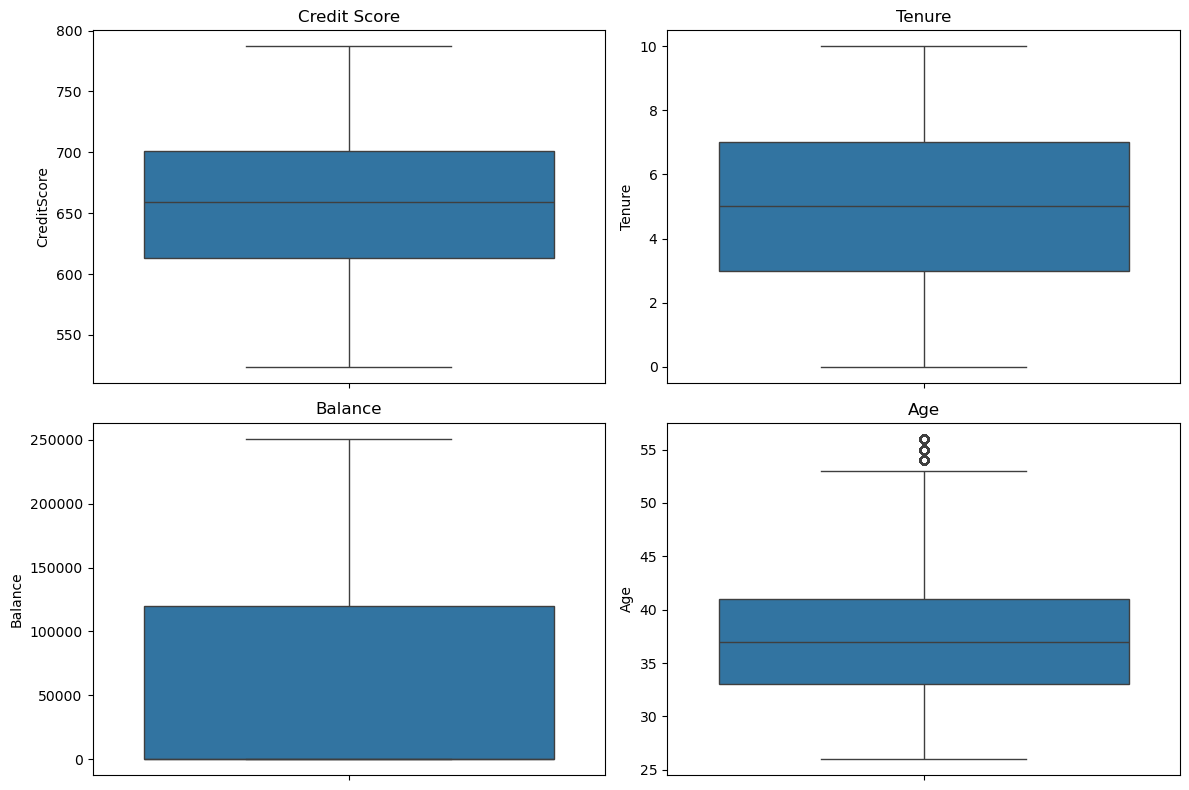

In [11]:
# Distribution and Outliers for each numerical column
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.boxplot(ax=axes[0, 0], data=df_train['CreditScore'])
axes[0, 0].set_title('Credit Score')

sns.boxplot(ax=axes[0, 1], data=df_train['Tenure'])
axes[0, 1].set_title('Tenure')

sns.boxplot(ax=axes[1, 0], data=df_train['Balance'])
axes[1, 0].set_title('Balance')

sns.boxplot(ax=axes[1, 1], data=df_train['Age'])
axes[1, 1].set_title('Age')

plt.tight_layout()
plt.show()

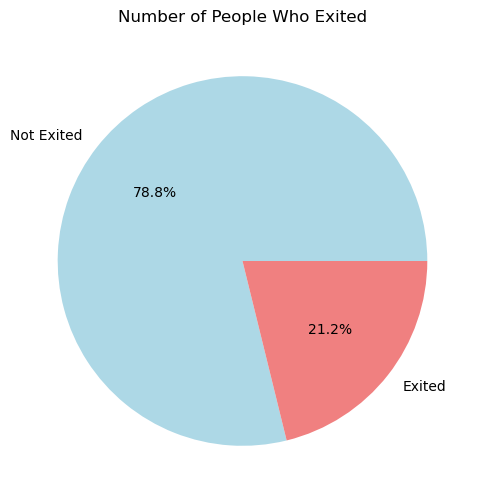

In [12]:
# Number of people who exited
plt.figure(figsize=(8, 6))
labels = ['Not Exited', 'Exited']
df_train['Exited'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightcoral'], labels=labels)
plt.title('Number of People Who Exited')
plt.ylabel('')
plt.show()

### Feature Engineering

In [13]:
# Feature Engineering
categorical_columns = ['Geography', 'Gender']
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

processor = ColumnTransformer([
    ('OHE', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns),
    ('STD_SCL', StandardScaler(), numerical_columns)
], remainder='passthrough')

X_train = df_train.drop(columns=['Exited', 'CustomerId', 'Surname', 'id'], errors='ignore')
y_train = df_train['Exited'] if 'Exited' in df_train.columns else pd.Series(np.zeros(len(df_train)))

X_train_processed = processor.fit_transform(X_train)
y_train_numpy = y_train.values.astype(np.float32)

X_test = df_test.drop(columns=['Exited', 'CustomerId', 'Surname', 'id'], errors='ignore')
y_test = df_test['Exited'] if 'Exited' in df_test.columns else pd.Series(np.zeros(len(df_test)))

X_test_processed = processor.transform(X_test)
y_test_numpy = y_test.values.astype(np.float32)

X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_numpy, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_numpy, dtype=torch.float32)

print(X_train_tensor.shape, y_train_tensor.shape)
print(X_test_tensor.shape, y_test_tensor.shape)

torch.Size([165034, 13]) torch.Size([165034])
torch.Size([110023, 13]) torch.Size([110023])


### Machine Learning Model

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(p=0.6)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        x = self.activation(self.fc4(x))
        x = self.dropout(x)
        x = self.activation(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x

### Model Training & Evaluation

In [15]:
# Parameters
BATCH_SIZE = 512
LEARNING_RATE = 3e-3
WEIGHT_DECAY = 3e-5


input_size = X_train_tensor.shape[1]
model = NeuralNetwork(input_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Move the model and data to the device
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Create data loaders for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

num_epochs = 20
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()  # Accumulate loss

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}")

    # Model evaluation
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in test_loader:
            outputs = model(inputs)  # Forward pass
            predictions = (torch.sigmoid(outputs.squeeze()) > 0.5).float()  # Binarize predictions
            test_correct += (predictions == labels).sum().item()  # Count correct predictions
            test_total += labels.size(0)  # Count total labels
    
    test_accuracy = test_correct / test_total  # Calculate accuracy
    test_accuracies.append(test_accuracy)
    print(f"Test Accuracy after Training: {test_accuracy:.2%}")

Using device: cpu
Epoch [1/20], Training Loss: 0.4474
Test Accuracy after Training: 81.07%
Epoch [2/20], Training Loss: 0.3930
Test Accuracy after Training: 81.18%
Epoch [3/20], Training Loss: 0.3843
Test Accuracy after Training: 84.04%
Epoch [4/20], Training Loss: 0.3822
Test Accuracy after Training: 83.23%
Epoch [5/20], Training Loss: 0.3799
Test Accuracy after Training: 84.70%
Epoch [6/20], Training Loss: 0.3801
Test Accuracy after Training: 84.63%
Epoch [7/20], Training Loss: 0.3792
Test Accuracy after Training: 85.35%
Epoch [8/20], Training Loss: 0.3791
Test Accuracy after Training: 86.19%
Epoch [9/20], Training Loss: 0.3785
Test Accuracy after Training: 84.04%
Epoch [10/20], Training Loss: 0.3773
Test Accuracy after Training: 85.92%
Epoch [11/20], Training Loss: 0.3790
Test Accuracy after Training: 85.49%
Epoch [12/20], Training Loss: 0.3777
Test Accuracy after Training: 87.10%
Epoch [13/20], Training Loss: 0.3772
Test Accuracy after Training: 85.48%
Epoch [14/20], Training Loss:

### Loss & Accuracy plots

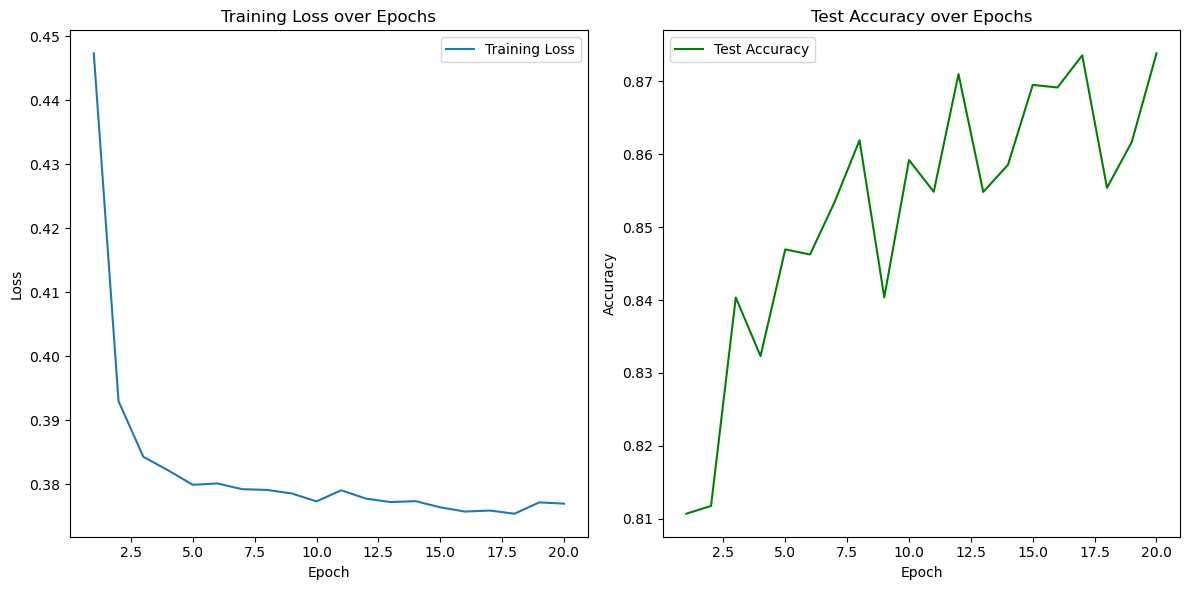

In [16]:
# Plot Training Loss and Test Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
